In [1]:
import ddr_tools as ddr #custom module
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact #interactive plots
import os
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter

In [2]:
# data (solution is phi_0 of TC_Matthieu)
rho = 0.25
sigma_in = 0.1
sigma_ex = 1
phi_datum = lambda x,y: 1.0 # first interface data
                            # second interface data (0)

# ref sol: expressions in x,y 
ref_sol_in = lambda x,y: 2*sigma_ex/(sigma_ex+sigma_in)*x -1
ref_sol_ex = lambda x,y: x*( 1+ (sigma_ex-sigma_in)/(sigma_ex+sigma_in)*(rho)**2/(x**2+y**2))

# wrapper ref sol that can be called by ref_sol(mesh,ino)
ref_sol = lambda mesh, dof, \
          rho=rho, ref_sol_in=ref_sol_in, ref_sol_ex=ref_sol_ex: \
          ddr.reference_solution(mesh, dof, rho, ref_sol_in, ref_sol_ex) 

                            # source term (0)
eta = 100                     # stability parameter

In [3]:
mesh = ddr.load_square_mesh("square_L1_N10.msh")

In [4]:
def move_critical_points(mesh, rho, N):
    for ino in range(mesh.Npoints_init):
        x = mesh.coords[ino,0]
        y = mesh.coords[ino,1]
        radius = np.sqrt(x**2+y**2)
        cos_theta = x/radius
        sin_theta = y/radius
        # If node is close to interface less than 1/10*mesh_size
        if (np.abs(rho-radius)<0.1*(1/N)):
            # internal nodes towards interior
            if (radius<rho):
                new_radius = radius - 0.1*(1/N)
            if (radius>rho):
                new_radius = radius + 0.1*(1/N)
            new_x = new_radius*cos_theta
            new_y = new_radius*sin_theta             
            mesh.coords[ino,0] = new_x
            mesh.coords[ino,1] = new_y
move_critical_points(mesh,rho,20)
ddr.break_mesh(mesh, rho)

In [5]:
# solve for a given mesh 
meshname = "square_L1_N10"
#meshname = "/home/aspadotto/meshes/square"
[mesh, G, G_no_sigma, S, M_gamma, N_gamma, b_phi, A, b, u, err] = \
        ddr.solve_problem(meshname+".msh", meshname+".vtk", \
                          rho, ref_sol, sigma_in, sigma_ex, eta, phi_datum)

In [5]:
def calc_energy_error (mesh, u, ref_sol, G_no_sigma, N_gamma, S):
    u_ref = np.array([ ref_sol(mesh,dof) for dof in range(mesh.Ndof)])
    err = u - u_ref
    contrib_1 = np.dot(np.dot(G_no_sigma,err),err)
    contrib_2 = np.dot(np.dot(N_gamma,err),err)
    contrib_3 = np.dot(np.dot(S,err),err)
    return np.sqrt(contrib_1+contrib_2+contrib_3)

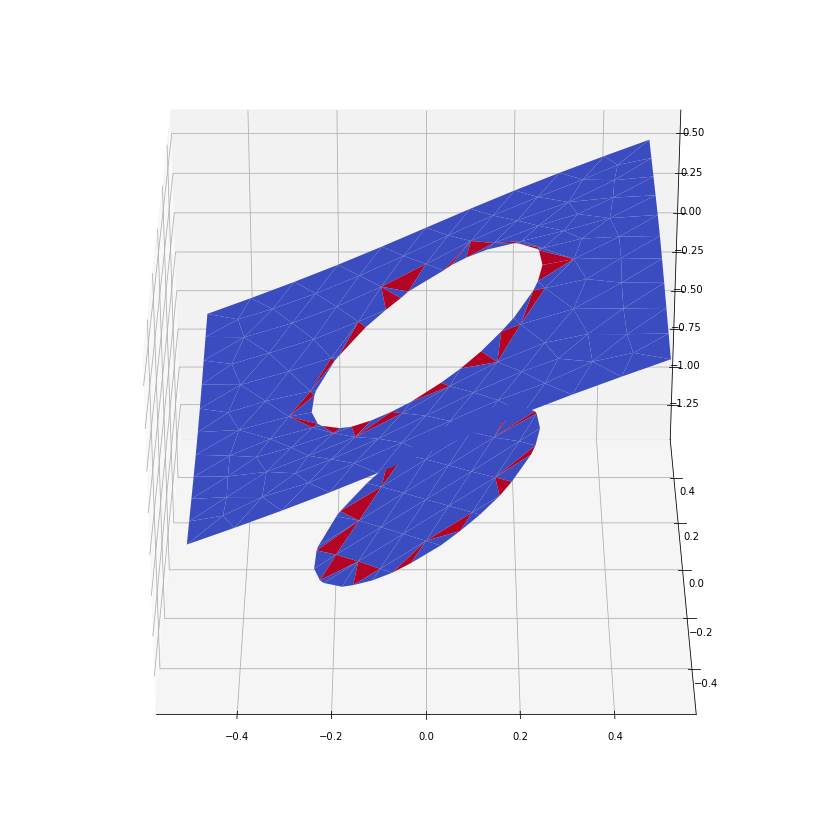

Error:  0.011360545027408353


In [4]:
ddr.plot_solution(mesh, u, elevation=30, azimuth=-90)
print ("Error: ", ddr.calc_L0_error(mesh,u,ref_sol))

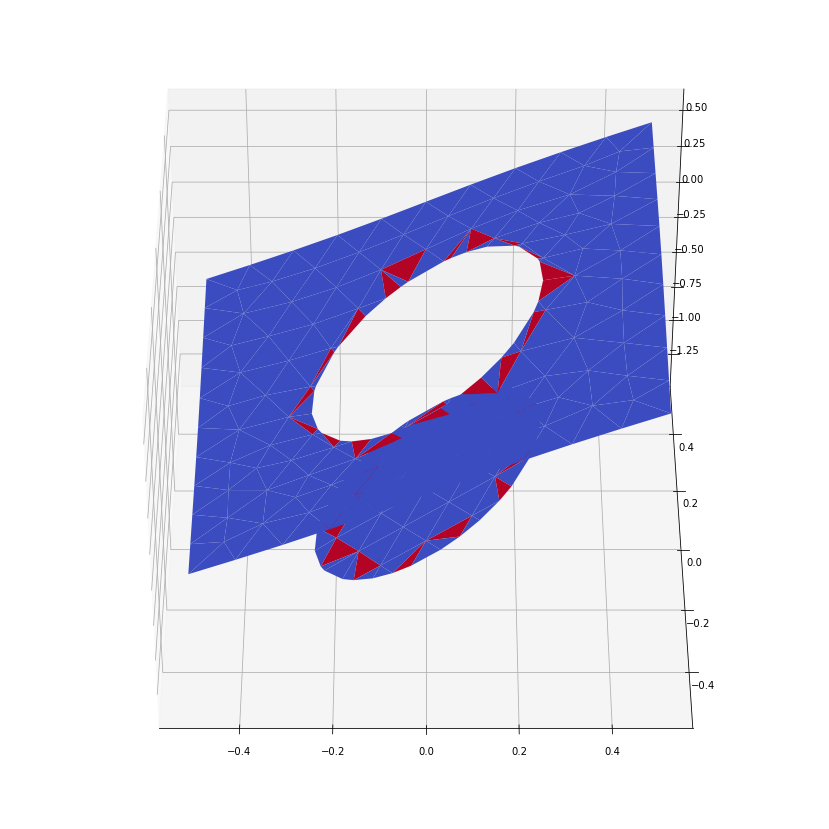

Error:  0.0


In [5]:
u_ref = np.array([ ref_sol(mesh,dof) for dof in range(mesh.Ndof)])
ddr.plot_solution(mesh, u_ref, elevation=40, azimuth=-90)
print ("Error: ", ddr.calc_L0_error(mesh,u_ref,ref_sol))

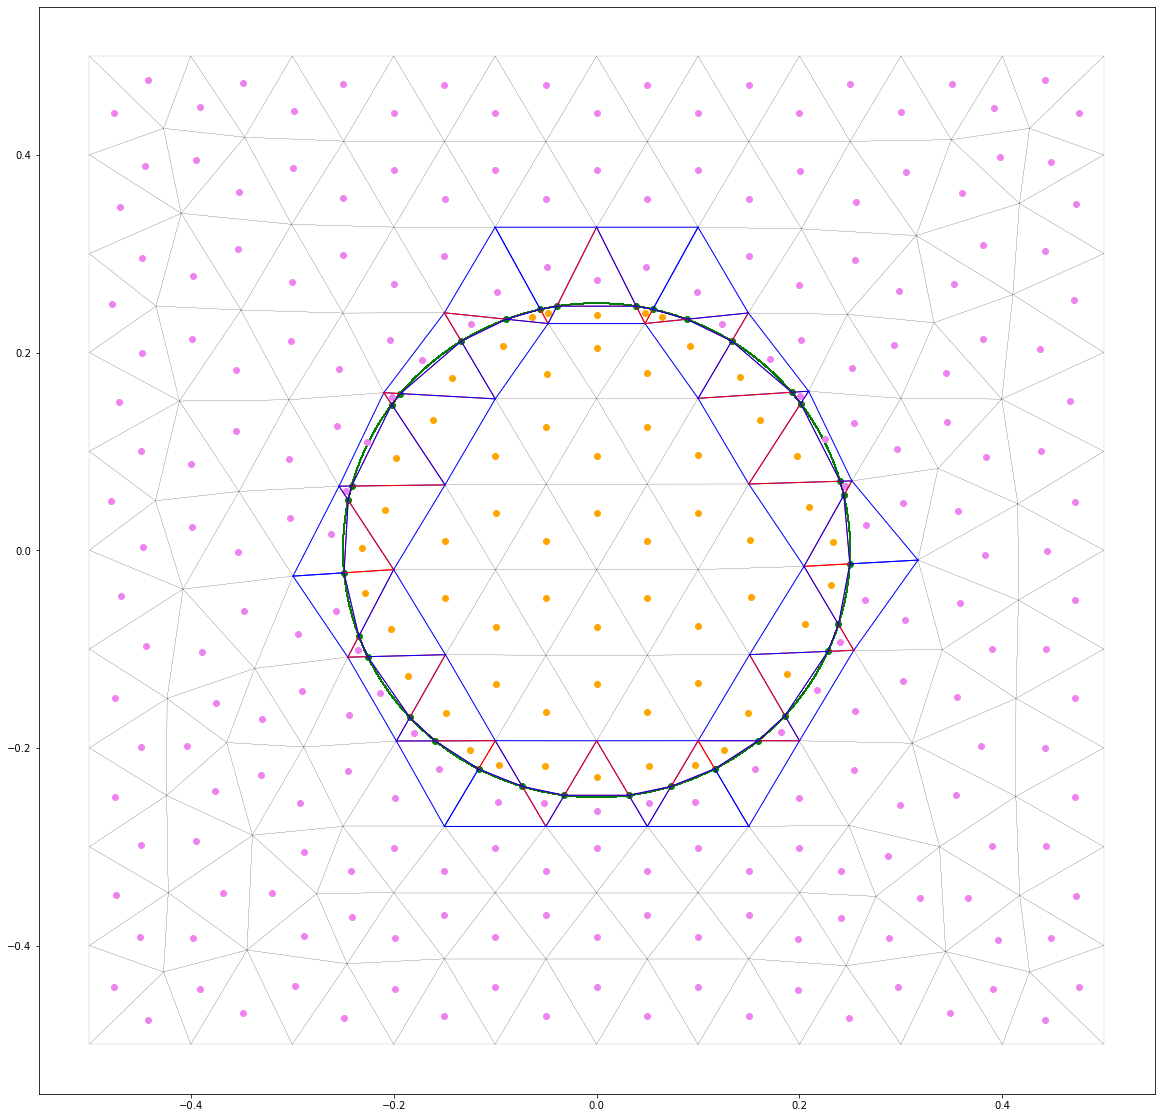

In [6]:
ddr.visualize_mesh(mesh,rho)

In [3]:
# CONVERGENCE STUDY: Solve problem for each mesh in the sequence and record error 
size_list = [5, 10, 20, 40]
mesh_filenames = ["square_L1_N"+str(size)+".msh" for size in size_list]
Meshes = []
G_matrices = []
G_no_sigma_matrices = []
S_matrices =[]
M_gamma_matrices = []
N_gamma_matrices = []
b_phi_matrices = []
solutions = []
errors_L0 = []
errors_energy = []
solution_filenames = ["square_L1_N"+str(size)+".vtk" for size in size_list]

for (i,N) in enumerate (size_list):
    [mesh, G, G_no_sigma, S, M_gamma, N_gamma, b_phi, A, b, u, err_L0, err_energy] = \
        ddr.solve_problem(mesh_filenames[i], solution_filenames[i], \
                          rho, ref_sol, sigma_in, sigma_ex, eta, phi_datum)
    Meshes.append(mesh)
    G_matrices.append(G)
    G_no_sigma_matrices.append(G_no_sigma)
    S_matrices.append(S)
    M_gamma_matrices.append(M_gamma)
    N_gamma_matrices.append(N_gamma)
    b_phi_matrices.append(b_phi)
    solutions.append(u)
    errors_L0.append(err_L0)
    errors_energy.append(err_energy)

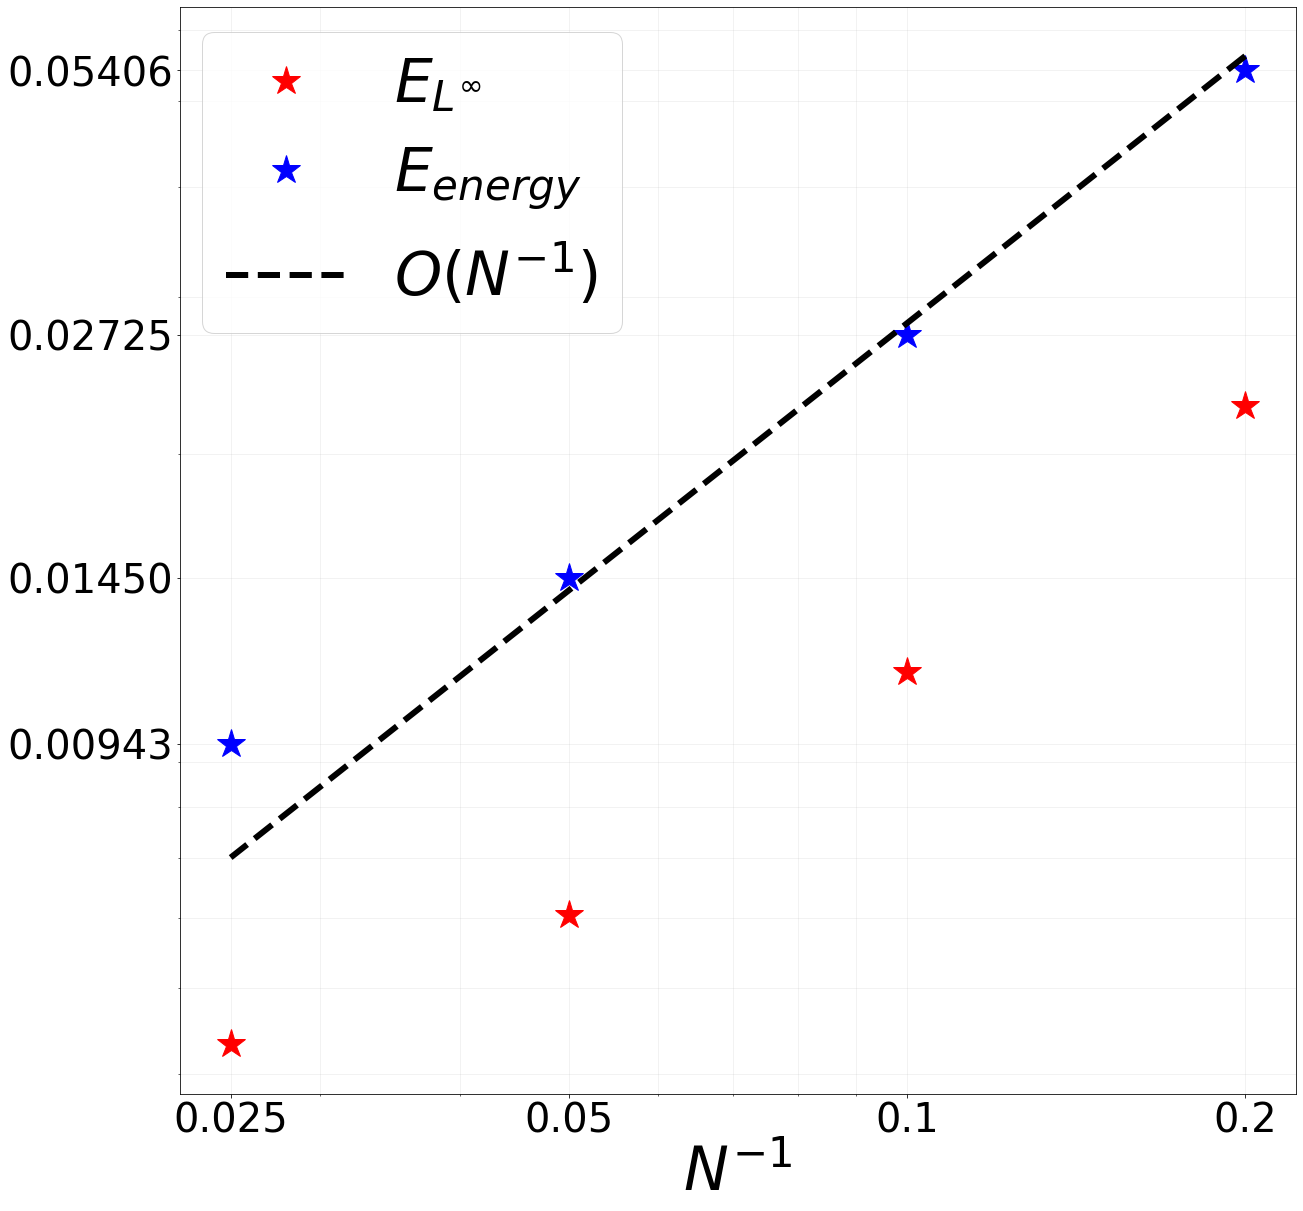

In [5]:
legend_size = 60
label_size = 40
fig_size = 20
line_width = 6
axis_name_size = 60
marker_size = 30

fig,ax = plt.subplots(figsize=(fig_size,fig_size))
h = [1/N for N in size_list]

ax.loglog(h,errors_L0, '*', label="$E_{L^\infty}$", markersize = marker_size, color="red")
ax.loglog(h,errors_energy, '*', label="$E_{energy}$", markersize = marker_size, color="blue")
ax.loglog(h,h/np.mean(h)*np.mean(errors_energy),'--', label="$O(N^{-1})$", color="black", linewidth= line_width )


# Customize tick formatting
#plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(h))
plt.gca().xaxis.set_minor_formatter(NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(NullFormatter())

# Set the ticks at each data point
plt.xticks(h,h)
plt.yticks(errors_energy)

#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
ax.tick_params(axis='x', which='both', labelsize=label_size)
ax.tick_params(axis='y', which='both', labelsize=label_size)
ax.set_xticks(h)

#grid
ax.grid(alpha=0.2,which='both')

# legend and axis label
legend = ax.legend(prop={'size': legend_size},loc=(0.02,0.7) ) 
ax.set_xlabel('$N^{-1}$',fontsize=axis_name_size)
#ax.set_ylabel('$$',fontsize=axis_name_size) 
# tick setting

#plt.show()
plt.savefig('L0_convergence.png')
ax.grid('on')

In [47]:
# data (for a basic test: u = y)
rho = 0.25
sigma_in = 1
sigma_ex = 1
phi_datum = lambda x,y: 0.0 # first interface data
                            # second interface data (0)

# ref sol: expressions in x,y 
ref_sol_linear = lambda x,y: y

# wrapper ref sol that can be called by ref_sol(mesh,ino)
ref_sol = lambda mesh, dof, \
          rho=rho, ref_sol_in=ref_sol_in, ref_sol_ex=ref_sol_ex: \
          ddr.reference_solution(mesh, dof, rho, ref_sol_linear, ref_sol_linear) 

                            # source term (0)
eta = 1e12                     # stability parameter

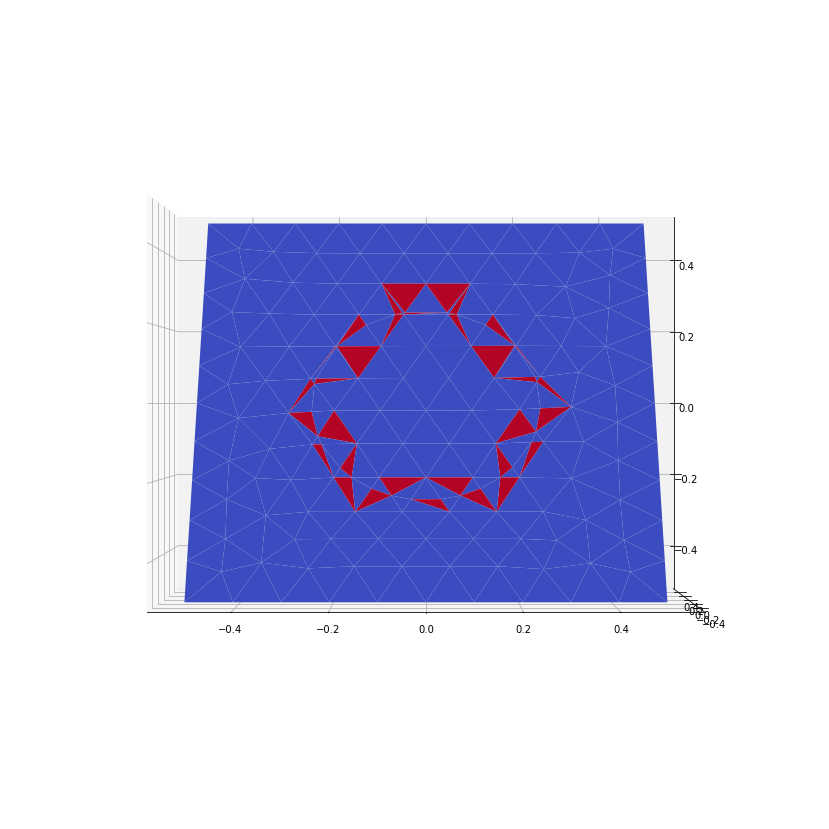

Error:  0.00014230847698259996


In [13]:
# solve for a given mesh 
meshname = "square_L1_N20"
#meshname = "/home/aspadotto/meshes/square"
[mesh, G, S, M_gamma, N_gamma, b_phi, A, b, u, err] = \
        ddr.solve_problem(meshname+".msh", meshname+".vtk", \
                          rho, ref_sol, sigma_in, sigma_ex, eta, phi_datum)

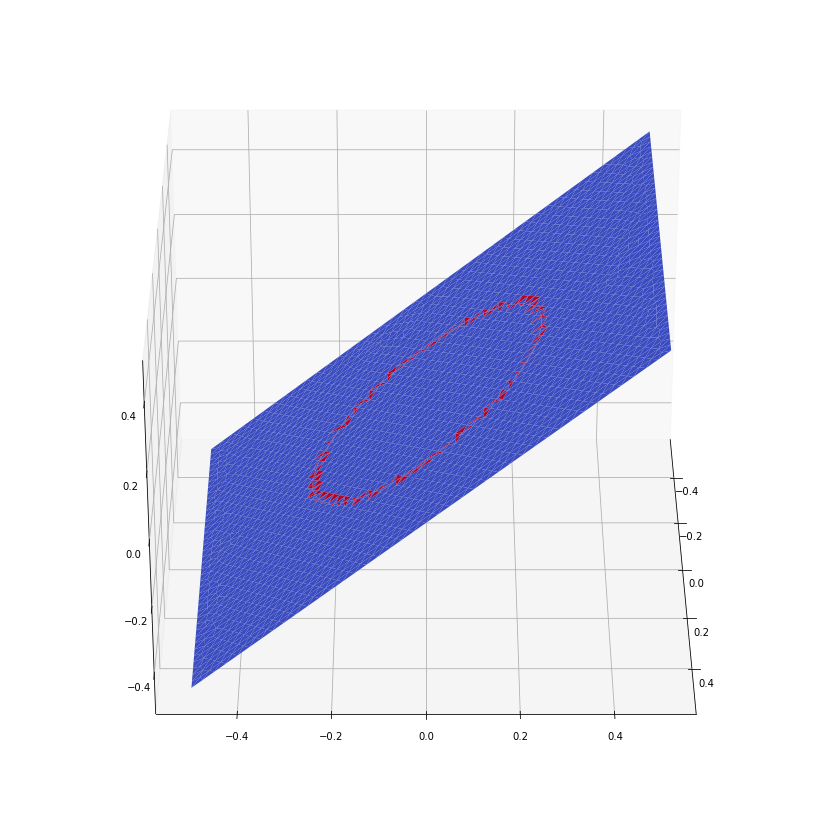

Error:  3.2923213938995666e-06


In [51]:
n = 3
ddr.plot_solution(Meshes[n], solutions[n], elevation=30, azimuth=0)
print ("Error: ", ddr.calc_L0_error(Meshes[n],solutions[n],ref_sol))

In [48]:
# CONVERGENCE STUDY: Solve problem for each mesh in the sequence and record error 
size_list = [5, 10, 20, 40]
mesh_filenames = ["square_L1_N"+str(size)+".msh" for size in size_list]
Meshes = []
G_matrices = []
S_matrices =[]
M_gamma_matrices = []
N_gamma_matrices = []
b_phi_matrices = []
solutions = []
errors = []
solution_filenames = ["square_L1_N"+str(size)+".vtk" for size in size_list]

for (i,N) in enumerate (size_list):
    [mesh, G, S, M_gamma, N_gamma, b_phi, A, b, u, err] = \
        ddr.solve_problem(mesh_filenames[i], solution_filenames[i], \
                          rho, ref_sol, sigma_in, sigma_ex, eta, phi_datum)
    Meshes.append(mesh)
    G_matrices.append(G)
    S_matrices.append(S)
    M_gamma_matrices.append(M_gamma)
    N_gamma_matrices.append(N_gamma)
    b_phi_matrices.append(b_phi)
    solutions.append(u)
    errors.append(err)

In [49]:
errors

[3.6913806033544994e-06,
 2.8450145513614356e-06,
 3.3553901792604535e-06,
 3.2923213938995666e-06]